**BiLSTM CNN W2v and FastText**

In [1]:
!pip install BnPReprocessing
!pip install livelossplot
! pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 3.7 MB/s 
     |████████████████████████████████| 381 kB 47.3 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but yo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 22.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings

folder_path = "/content/drive/MyDrive/model_imp_w2vec/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 4.5 s, sys: 640 ms, total: 5.14 s
Wall time: 9.28 s


## 1 . Initial and Fundamental Steps

### 1.1 Load data and packages

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_excel('/content/drive/MyDrive/model imp w2vec/be_data_no_un_combined.xlsx')
df

,Label,Text
0,Disgust,Dakhachish ai to tui svf are chala..to jeet d...
1,Disgust,Romantic comedy te je kikore eto vulgar jinish...
2,Sadness,Shokal thake burger r grill khaite mon chai bu...
3,Joy,jakhon dekhbi banglar chhele-meye banglay par...
4,Disgust,Mymensingh er manush eto kharap kn : ( na obos...
...,...,...
10225,Fear,eto damra polpain der sathe football khele nij...
10226,Joy,# ASKBOSS Boss er release er agerdin r Boss2 ...
10227,Fear,telapoka khub voyanok
10228,Disgust,Ekta fairy tale theke adopted movie te etotai ...


### 1.2 Checking corresponding rows for Nan values

In [6]:
df[df.isna().any(axis=1)]

,Label,Text


### 1.3 As only few rows with NaN , dropping it

In [7]:
df.Label.value_counts()

Joy         2584
Anger       1677
Surprise    1571
Sadness     1558
Disgust     1430
Fear        1410
Name: Label, dtype: int64

### 1.5 Mapping the classes to integer(standerd procedure)

In [8]:
map_class = dict(zip(df.Label.astype("category").cat.codes, df.Label))
map_class

{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Joy', 4: 'Sadness', 5: 'Surprise'}

#Mapping encoding

In [9]:
df['enc_label'] = df['Label'].replace({'Joy': 0,'Disgust':  3,'Anger' :4,
                                                       'Sadness': 1,'Surprise':2,'Fear': 5})

In [10]:
df.head(2)

,Label,Text,enc_label
0,Disgust,Dakhachish ai to tui svf are chala..to jeet d...,3
1,Disgust,Romantic comedy te je kikore eto vulgar jinish...,3


In [11]:
df.shape

(10230, 3)

#Cleaning

In [12]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [13]:
def get_becodemixed_stop_words():
    #swdf1 = pd.read_csv("/content/drive/MyDrive/automated_tamil_text_classification-master/data/TamilNLP_TamilStopWords.txt",  header=None) 
    swdf2 = pd.read_csv("/content/drive/MyDrive/model imp w2vec/custom_becodemixed_stopwords.txt",  header=None) 
    #sw1 = swdf1[0].tolist()
    sw2 = swdf2[0].tolist()
    #tamil_stop_words = list(set(sw1 + sw2))
    becodemixed_stop_words = list(sw2)
    return becodemixed_stop_words

In [14]:
# #removing URLs and Punctuations
# #train_data['cleaned'] = train_data['tweet'].apply(remove_url)
# #Removing punctuations


# becodemixed_stop_words = get_becodemixed_stop_words()
# valid_data['Texts'] = valid_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))
# train_data['Texts'] = train_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))
# test_data['Texts'] = test_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))

# train_data['cleaned'] = train_data['Texts'].apply(text_cleaning)
# valid_data['cleaned'] = valid_data['Texts'].apply(text_cleaning)
# test_data['cleaned'] = test_data['Texts'].apply(text_cleaning)


# ## Data samples after cleaning
# print("Original Data:===\n",train_data.Text[0],"\nCleaned Data:===\n",train_data.cleaned[0],)

In [15]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations


becodemixed_stop_words = get_becodemixed_stop_words()
df['Texts'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))


df['cleaned'] = df['Texts'].apply(text_cleaning)



## Data samples after cleaning
print("Original Data:===\n",df.Text[0],"\nCleaned Data:===\n",df.cleaned[0],)

Original Data:===
  Dakhachish ai to tui svf are chala..to jeet dar collection to fake blban e to ... sir manush boka noi 
Cleaned Data:===
 dakhachish tui svf are chalato jeet dar collection fake blban sir manush boka noi


## Data Stats

In [16]:
sentences = df['Text'].values
# sentences = df[df['classes']==5]['TEXT'].values

len(sentences)

10230

# 2 . PreProcessing

In [ ]:
import BnPreprocessing as pp

def get_cleaned(dfs, col):
  dfs[col] = dfs[col].apply(lambda x: pp.remove_punc(str(x)))
  dfs[col] = dfs[col].apply(lambda x: pp.remove_nonBangla(str(x)))
  dfs[col] = dfs[col].apply(lambda x: pp.remove_digits(str(x)))
  dfs[col] = dfs[col].apply(lambda x: pp.remove_emoticons(str(x)))
  return dfs

raw_train_data = get_cleaned(raw_train_data, 'cleaned')
raw_val_data = get_cleaned(raw_val_data, 'cleaned')
raw_test_data = get_cleaned(raw_test_data, 'cleaned')

# 3 . Train/ Test/ Val Split and Feature Extraction(TfIdf)

In [17]:
from sklearn.model_selection import train_test_split

sentences = df['Text'].values
target = df['enc_label'].values

# train:test = 90:10
sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, target, test_size=0.11, random_state=2000)

# train:validation = 85:15
sentences_train, sentences_val, y_train, y_val = train_test_split(
   sentences_train, y_train, test_size=0.13, random_state=2000)


#Creating training data
# sentences_train = raw_train_data.cleaned.tolist()
# y_train = np.array(raw_train_data.labels)

# #Creating validation data
# sentences_val = raw_val_data.cleaned.tolist()
# y_val = np.array(raw_val_data.labels)

# #Creating testing data
# sentences_test = raw_test_data.cleaned.tolist()
# y_test = np.array(raw_test_data.labels)

In [18]:
data_pick = [sentences_train, sentences_val, sentences_test, y_train, y_val ,y_test]
import pickle
with open("data_pick.pkl", "wb") as p:
  pickle.dump(data_pick, p)

In [19]:
import pickle
with open("data_pick.pkl", "rb") as p:
  data_pick = pickle.load(p)

In [20]:
!cp data_pick.pkl "/content/drive/MyDrive/"

In [21]:
sentences_train, sentences_val, sentences_test, y_train, y_val ,y_test = data_pick

In [22]:
from sklearn.model_selection import train_test_split

sentences = df['Text'].values
target = df['enc_label'].values

# train:test = 90:10
sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, target, test_size=0.10, random_state=2000)

# # train:validation = 85:15
sentences_train, sentences_val, y_train, y_val = train_test_split(
   sentences_train, y_train, test_size=0.11, random_state=2000)

from sklearn.feature_extraction.text import TfidfVectorizer

def tokenizer(text):
  return text.split()

# vectorizer = TfidfVectorizer(tokenizer = tokenizer, ngram_range=(1,2), max_df = 0.06, min_df = 0.0006)
vectorizer = TfidfVectorizer(tokenizer = tokenizer, ngram_range=(1,1))
vectorizer = vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [23]:
#  sentences_val , sentences_test = sentences_test , sentences_val
#  y_val , y_test = y_test, y_val

In [24]:
sentences_train.shape, sentences_test.shape, sentences_val.shape

((8194,), (1023,), (1013,))

In [25]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({0: 2061, 1: 1261, 2: 1267, 3: 1151, 4: 1327, 5: 1127}),
 Counter({0: 270, 1: 154, 2: 138, 3: 142, 4: 182, 5: 137}))

#Classwise train/validation/test set distribution

In [26]:
from collections import Counter
Counter(y_train), Counter(y_val), Counter(y_test)

(Counter({0: 2061, 1: 1261, 2: 1267, 3: 1151, 4: 1327, 5: 1127}),
 Counter({0: 253, 1: 143, 2: 166, 3: 137, 4: 168, 5: 146}),
 Counter({0: 270, 1: 154, 2: 138, 3: 142, 4: 182, 5: 137}))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenizer(text):
  return text.split()

# vectorizer = TfidfVectorizer(tokenizer = tokenizer, ngram_range=(1,2), max_df = 0.06, min_df = 0.0006)
vectorizer = TfidfVectorizer(tokenizer = tokenizer, ngram_range=(1,1))
vectorizer = vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

### Functions for Evaluation Metrics

In [28]:
def get_scores(y_test, y_pred):
  from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, y_pred)

  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, y_pred,  average=None)

  # precision:  tp / (tp + fp)
  precision = precision_score(y_test, y_pred,  average=None)

  # recall:  tp / (tp + fn)
  recall = recall_score(y_test, y_pred,  average=None)

  return {
      'accuracy':accuracy,
      'f1':f1, 
      'precision':precision, 
      'recall':recall
  }

def get_score_table(y_test, y_pred, metrics=None):
    from prettytable import PrettyTable

    if metrics is None : metrics = ['f1', 'precision', 'recall', 'accuracy']
    dc= get_scores(y_test, y_pred)
    if 'accuracy' in metrics:
      print('Accuracy: {}'.format(dc['accuracy']))
      metrics.remove('accuracy')

    classes = list(set(df.Label.values))

    t = PrettyTable(['class']+metrics)
    for i in range(len(map_class)):
        t.add_row([map_class[i]]+[dc[d][i] for d in metrics])
    print(t)

# 4. Baseline ML Models

### 4.2 ML Algos

#### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='newton-cg')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
get_score_table(y_test, y_pred)

Accuracy: 0.7702834799608993
+----------+--------------------+--------------------+--------------------+
|  class   |         f1         |     precision      |       recall       |
+----------+--------------------+--------------------+--------------------+
|  Anger   | 0.7945205479452054 | 0.7388535031847133 | 0.8592592592592593 |
| Disgust  | 0.6923076923076924 |        0.75        | 0.6428571428571429 |
|   Fear   | 0.7596899224806202 | 0.8166666666666667 | 0.7101449275362319 |
|   Joy    | 0.740484429065744  | 0.7278911564625851 | 0.7535211267605634 |
| Sadness  | 0.775623268698061  | 0.7821229050279329 | 0.7692307692307693 |
| Surprise | 0.835820895522388  | 0.8549618320610687 | 0.8175182481751825 |
+----------+--------------------+--------------------+--------------------+


#### Support Vector Classifier

In [30]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

get_score_table(y_test, y_pred)

Accuracy: 0.7849462365591398
+----------+--------------------+--------------------+--------------------+
|  class   |         f1         |     precision      |       recall       |
+----------+--------------------+--------------------+--------------------+
|  Anger   | 0.7949640287769782 | 0.7727272727272727 | 0.8185185185185185 |
| Disgust  | 0.6819672131147541 | 0.6887417218543046 | 0.6753246753246753 |
|   Fear   | 0.8045977011494252 | 0.8536585365853658 | 0.7608695652173914 |
|   Joy    | 0.7728813559322034 | 0.7450980392156863 | 0.8028169014084507 |
| Sadness  | 0.8011204481792719 | 0.8171428571428572 | 0.7857142857142857 |
| Surprise | 0.8529411764705882 | 0.8592592592592593 | 0.8467153284671532 |
+----------+--------------------+--------------------+--------------------+


#### Multinomial Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)
y_pred = classifier.predict(X_test.toarray())

get_score_table(y_test, y_pred)

Accuracy: 0.6920821114369502
+----------+--------------------+--------------------+---------------------+
|  class   |         f1         |     precision      |        recall       |
+----------+--------------------+--------------------+---------------------+
|  Anger   | 0.693298969072165  | 0.5316205533596838 |  0.9962962962962963 |
| Disgust  | 0.5555555555555556 |       0.8125       | 0.42207792207792205 |
|   Fear   | 0.7136563876651982 | 0.9101123595505618 |  0.5869565217391305 |
|   Joy    | 0.6079295154185022 | 0.8117647058823529 |  0.4859154929577465 |
| Sadness  | 0.7440476190476191 | 0.8116883116883117 |  0.6868131868131868 |
| Surprise | 0.8048780487804877 | 0.908256880733945  |  0.7226277372262774 |
+----------+--------------------+--------------------+---------------------+


#### KNeighborsClassifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10, p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

get_score_table(y_test, y_pred)

Accuracy: 0.5913978494623656
+----------+---------------------+--------------------+---------------------+
|  class   |          f1         |     precision      |        recall       |
+----------+---------------------+--------------------+---------------------+
|  Anger   |  0.6733333333333332 | 0.6121212121212121 |  0.7481481481481481 |
| Disgust  |  0.4791666666666667 | 0.5149253731343284 | 0.44805194805194803 |
|   Fear   |  0.5599999999999999 | 0.5185185185185185 |  0.6086956521739131 |
|   Joy    | 0.47540983606557374 | 0.5686274509803921 |  0.4084507042253521 |
| Sadness  |  0.6017191977077364 | 0.6287425149700598 |  0.5769230769230769 |
| Surprise |  0.6566037735849056 |     0.6796875      |  0.635036496350365  |
+----------+---------------------+--------------------+---------------------+


#### Decision Tree

In [33]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

get_score_table(y_test, y_pred)

Accuracy: 0.761485826001955
+----------+--------------------+--------------------+--------------------+
|  class   |         f1         |     precision      |       recall       |
+----------+--------------------+--------------------+--------------------+
|  Anger   | 0.7910447761194029 | 0.7969924812030075 | 0.7851851851851852 |
| Disgust  | 0.6513157894736842 |        0.66        | 0.6428571428571429 |
|   Fear   | 0.7687296416938111 | 0.6982248520710059 | 0.855072463768116  |
|   Joy    | 0.7147766323024054 | 0.697986577181208  | 0.7323943661971831 |
| Sadness  | 0.7976539589442815 | 0.8553459119496856 | 0.7472527472527473 |
| Surprise | 0.8239700374531835 | 0.8461538461538461 | 0.8029197080291971 |
+----------+--------------------+--------------------+--------------------+


#### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
get_score_table(y_test, y_pred)

Accuracy: 0.49560117302052786
+----------+---------------------+---------------------+---------------------+
|  class   |          f1         |      precision      |        recall       |
+----------+---------------------+---------------------+---------------------+
|  Anger   |  0.5598591549295775 |  0.5335570469798657 |  0.5888888888888889 |
| Disgust  |  0.3726235741444867 | 0.44954128440366975 |  0.3181818181818182 |
|   Fear   |  0.4887218045112782 |      0.5078125      | 0.47101449275362317 |
|   Joy    | 0.36641221374045807 |         0.4         |  0.3380281690140845 |
| Sadness  |  0.5165562913907285 |  0.4317343173431734 |  0.6428571428571429 |
| Surprise |  0.5897435897435899 |  0.711340206185567  |  0.5036496350364964 |
+----------+---------------------+---------------------+---------------------+


# Word2Vec

In [35]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

In [36]:
# sentences_train
["i am a boy", 'i am a girl']

[['i','am','a','boy'], ['i', 'am', 'a', 'girl']]

[['i', 'am', 'a', 'boy'], ['i', 'am', 'a', 'girl']]

In [37]:
sentence_list = []
for s in sentences_train:
  sentence_list.append(s.split())

In [38]:
w2v_model = gensim.models.Word2Vec(sentence_list, size=100, window=6, min_count=1, workers=38, sg=1)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 17925 - Embedding Dim: 100


In [39]:
w2v_weights.shape

(17925, 100)

# GloVe

In [40]:
! pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from glove import Corpus, Glove
#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(sentence_list, window=6)

glove = Glove(no_components=100, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=38, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 38 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [42]:
glove_weights = glove.word_vectors
glove_weights.shape

(17925, 100)

# Fasttext

## Training

In [43]:
ft_model = gensim.models.FastText(sentence_list, size=35, window=4, min_count=7, workers=8, sg=1)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
ft_weights = ft_model.wv.vectors
vocab_size, embedding_size = ft_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 2250 - Embedding Dim: 35


# 5 . DNN Approach

### 5.1 Defining necessary functions

In [44]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'royalblue', label='Training acc', marker="o")
    plt.plot(x, val_acc, 'coral', label='Validation acc', marker="o")
    plt.title('(a)')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'royalblue', label='Training loss',marker="o")
    plt.plot(x, val_loss, 'coral', label='Validation loss',marker="o")
    plt.title('(b)')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def reset_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            var.assign(initializer(var.shape, var.dtype))

### 5.2 Preparing data for the Network

In [45]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train.shape

(8194, 6)

In [46]:
sentences_train

array(['Biden vai room e emonvabe chillay uthe, monehoy baj porse',
       ' Besirvag somoi pore imotione hok r realitir karonei hok ai kothai mone hoi aneker.kintu anek valo somoi…',
       'WTF where the hell are my eggs?', ...,
       ' Jor koira niya jaite hobe boka take 😠',
       'sara din murgi khete er valo lage na',
       'tui jibone ekbarow sir er mair khasnai?'], dtype=object)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
vocab_size = vocab_size  
embedding_dim = 100
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [48]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'ami': 9,
 'e': 5,
 'er': 4,
 'eto': 8,
 'khub': 10,
 'ki': 6,
 'movie': 7,
 'na': 2,
 'ta': 3}

In [49]:
len(word_index)

14750

In [50]:
train_sequences = tokenizer.texts_to_sequences(sentences_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(train_sequences[10])

[1, 9, 380, 1, 1763, 1, 120, 206, 1, 1957, 57, 19, 10, 370]


In [51]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

10
100
18
100
14
100


In [52]:
validation_sequences = tokenizer.texts_to_sequences(sentences_val)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(sentences_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [53]:
test_padded.shape

(1023, 100)

In [54]:
train_padded.shape

(8194, 100)

In [55]:
validation_padded.shape

(1013, 100)

In [56]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(sentences_train[10])

<OOV> ami ekhono <OOV> shuni <OOV> koto sundor <OOV> mimi k amar khub pochondo ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
 Haan ami ekhono gangulo shuni ... Pupe koto sundor chiloo.. Mimi k amar khub pochondo


#6 . BiLSTM(Tuned)

In [57]:
# reset_weights(model)
model = Sequential()
model.add(layers.Input(name='inputs',shape=[max_length]))
# model.add(layers.Embedding(vocab_size, 100, input_length=max_length)) #embedding dim=100
model.add(layers.Embedding(17925, 100, weights=[w2v_weights])) #For word2vec
# model.add(layers.Embedding(vocab_size, 100, weights=[glove_weights])) #For golve
# model.add(layers.Embedding(vocab_size, 35, weights=[ft_weights])) #For fasttext

model.add(layers.Bidirectional(layers.LSTM(128)))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='logcosh', 
            optimizer=opt, 
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1792500   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 2,028,538
Trainable params: 2,028,538
Non-trainable params: 0
______________________________________________

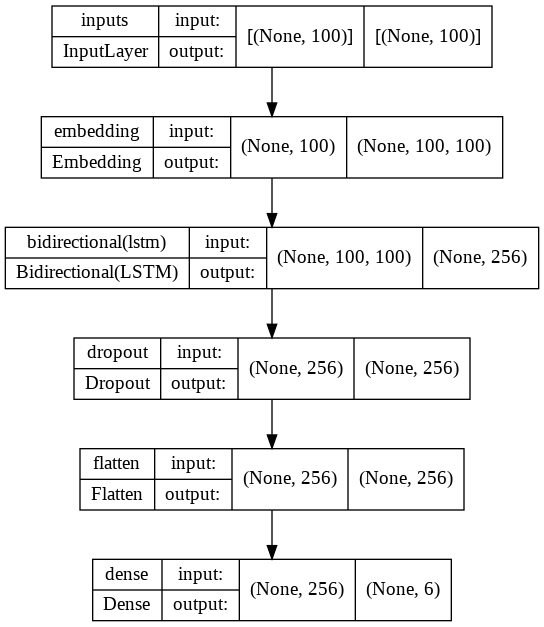

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model93_plot.png', show_shapes=True, show_layer_names=True)

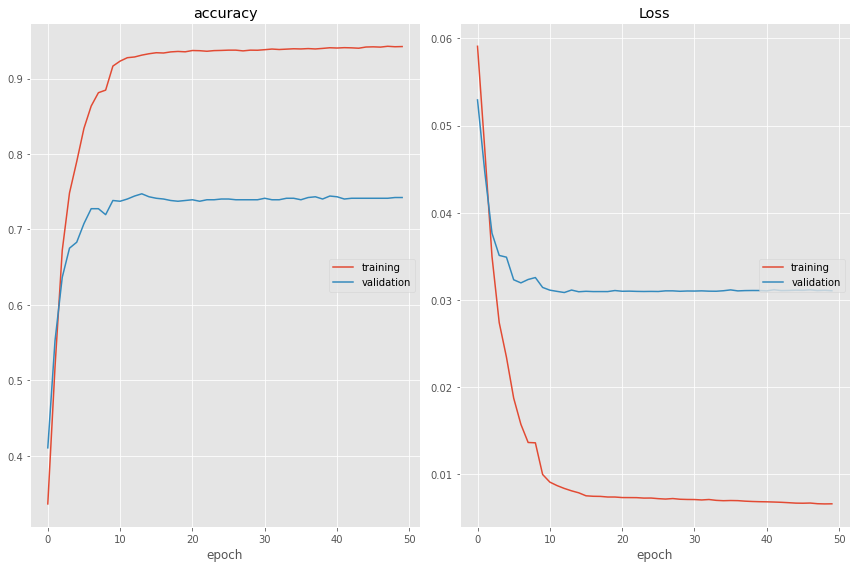

accuracy
	training         	 (min:    0.336, max:    0.943, cur:    0.942)
	validation       	 (min:    0.411, max:    0.747, cur:    0.742)
Loss
	training         	 (min:    0.007, max:    0.059, cur:    0.007)
	validation       	 (min:    0.031, max:    0.053, cur:    0.031)

Epoch 50: saving model to model_weights.h5
257/257 [==============================] - 5s 20ms/step - loss: 0.0066 - accuracy: 0.9424 - val_loss: 0.0311 - val_accuracy: 0.7423 - lr: 1.0000e-05


In [59]:
num_epochs = 50
# batch_size = 30

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]


history = model.fit(train_padded, y_train, 
                  epochs=num_epochs, 
                  validation_data=(validation_padded, y_val),
                  # batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# plot

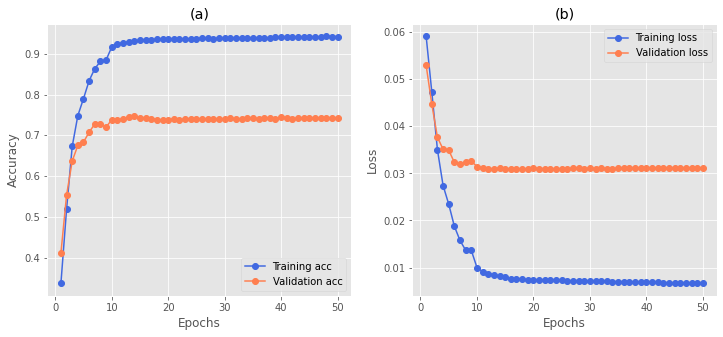

In [60]:
plot_history(history.history)
plt.savefig('acc_loss.png', dpi=300)

In [61]:
history

In [62]:
with open('history.pkl', 'wb') as p:
  pickle.dump(history, p)
import pickle
with open('history.pkl', 'rb') as p:
  history = pickle.load(p)

INFO:tensorflow:Assets written to: ram://d66b6b46-764a-451a-8400-e9b9feb0baf3/assets


INFO:tensorflow:Assets written to: ram://d66b6b46-764a-451a-8400-e9b9feb0baf3/assets


In [63]:
# !cp "/content/drive/My Drive/nlp/emotion/AED 29k/RNN/sg1w2v/model_weights.h5" "/content/"
# !cp "/content/drive/My Drive/nlp/emotion/AED 29k/RNN/sg1w2v/model.json" "/content/"
!cp history.pkl "/content/drive/MyDrive/"

In [64]:
from keras.models import model_from_json
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model_weights.h5")
print("Loaded model from disk")


Y_pred = loaded_model.predict(test_padded)
y_pred = np.argmax(Y_pred, axis=1)
get_score_table(y_test, y_pred)

Loaded model from disk
Accuracy: 0.750733137829912
+----------+--------------------+--------------------+--------------------+
|  class   |         f1         |     precision      |       recall       |
+----------+--------------------+--------------------+--------------------+
|  Anger   | 0.7851851851851852 | 0.7851851851851852 | 0.7851851851851852 |
| Disgust  | 0.6709265175718849 | 0.660377358490566  | 0.6818181818181818 |
|   Fear   | 0.7252747252747253 | 0.7333333333333333 | 0.717391304347826  |
|   Joy    | 0.7357142857142859 | 0.7463768115942029 | 0.7253521126760564 |
| Sadness  | 0.7452054794520548 | 0.7431693989071039 | 0.7472527472527473 |
| Surprise | 0.8218181818181818 | 0.8188405797101449 | 0.8248175182481752 |
+----------+--------------------+--------------------+--------------------+


In [65]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
conf_mat=confusion_matrix(y_test, y_pred)
print(conf_mat)

Confusion Matrix
[[212  29  10  11   7   1]
 [ 17 105   2  10  16   4]
 [ 13   5  99   4  11   6]
 [ 16  11   6 103   6   0]
 [  9   5  11   7 136  14]
 [  3   4   7   3   7 113]]


#InputOutput

#'Joy': 0, 'Disgust': 3, 'Anger':4,  'Sadness':1, 'Surprise':2, 'Fear':5


In [66]:
 input_data = ["padda shetu amader jonne proud bishoy"]

In [67]:
input_sequences = tokenizer.texts_to_sequences(input_data)
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(input_sequences)


[[1, 1, 73, 799, 1081, 1605]]


In [68]:
Y_pred = loaded_model.predict(input_padded)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[0]


In [69]:
input_data = ["padda shetu amader jonne gorbo er bishoy"]

In [70]:
input_sequences = tokenizer.texts_to_sequences(input_data)
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(input_sequences)


[[1, 1, 73, 799, 1, 4, 1605]]


In [71]:
Y_pred = loaded_model.predict(input_padded)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[0]


In [72]:
input_data = ["Movie ta amar kharap legeche"]

In [73]:
input_sequences = tokenizer.texts_to_sequences(input_data)
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(input_sequences)


[[7, 3, 19, 36, 339]]


In [74]:
Y_pred = loaded_model.predict(input_padded)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[1]


#Confusion matrix

In [ ]:
import numpy as np
conf_mat = np.array([[221,  26,   7,  8,   4,   4],
       [ 21, 102,   1,  11,  18,   1],
       [ 16,   6, 103,  3,  7,  3],
       [ 14,   10, 3,   118,   6,   1],
       [ 6,  8,   9,   10, 138,   11],
       [ 6,   6,   8,   1,  8, 108]])

In [ ]:
# conf_mat[0][0], conf_mat[0][4] = 216, 53
# conf_mat

In [ ]:
class_names = ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [ ]:
["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

['21.39%',
 '2.52%',
 '0.68%',
 '0.77%',
 '0.39%',
 '0.39%',
 '2.03%',
 '9.87%',
 '0.10%',
 '1.06%',
 '1.74%',
 '0.10%',
 '1.55%',
 '0.58%',
 '9.97%',
 '0.29%',
 '0.68%',
 '0.29%',
 '1.36%',
 '0.97%',
 '0.29%',
 '11.42%',
 '0.58%',
 '0.10%',
 '0.58%',
 '0.77%',
 '0.87%',
 '0.97%',
 '13.36%',
 '1.06%',
 '0.58%',
 '0.58%',
 '0.77%',
 '0.10%',
 '0.77%',
 '10.45%']

In [ ]:
# for cf in conf_mat:
#   print(cf/np.sum(cf))
["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in conf_mat]).flatten()]

['81.85%',
 '9.63%',
 '2.59%',
 '2.96%',
 '1.48%',
 '1.48%',
 '13.64%',
 '66.23%',
 '0.65%',
 '7.14%',
 '11.69%',
 '0.65%',
 '11.59%',
 '4.35%',
 '74.64%',
 '2.17%',
 '5.07%',
 '2.17%',
 '9.21%',
 '6.58%',
 '1.97%',
 '77.63%',
 '3.95%',
 '0.66%',
 '3.30%',
 '4.40%',
 '4.95%',
 '5.49%',
 '75.82%',
 '6.04%',
 '4.38%',
 '4.38%',
 '5.84%',
 '0.73%',
 '5.84%',
 '78.83%']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True, 
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = ["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in conf_mat]).flatten()]

    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        # plt.savefig('filename.png', dpi=300)
    else:
        plt.xlabel(stats_text)
        # plt.savefig('filename.png', dpi=300)
    if title:
        plt.title(title)
        # plt.savefig('filename.png', dpi=300)

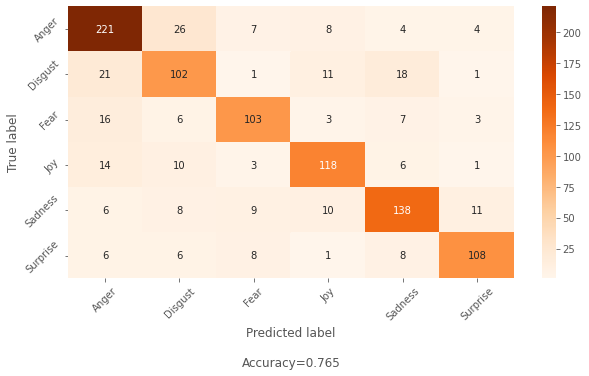

In [ ]:
make_confusion_matrix(conf_mat, figsize=(10,5),percent=False,categories=class_names,cbar=True,cmap='Oranges')
# plt.xlabel('Predicted label')
plt.savefig('conf_mat.png', dpi=300)

In [ ]:
'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 
'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 
'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 
'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 
'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 
'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 
'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno'

('gnuplot2_r',
 'gnuplot_r',
 'gray',
 'gray_r',
 'hot',
 'hot_r',
 'hsv',
 'hsv_r',
 'icefire',
 'icefire_r',
 'inferno',
 'inferno')

In [ ]:
# mat = np.array([[48,2],[1,79]])
# mat = np.array([[50,4],[2,74]])
# make_confusion_matrix(mat, figsize=(6,3),percent=False,categories=['No','Yes'],cbar=True,cmap='Blues')

# 7 . CNN(Tuned)

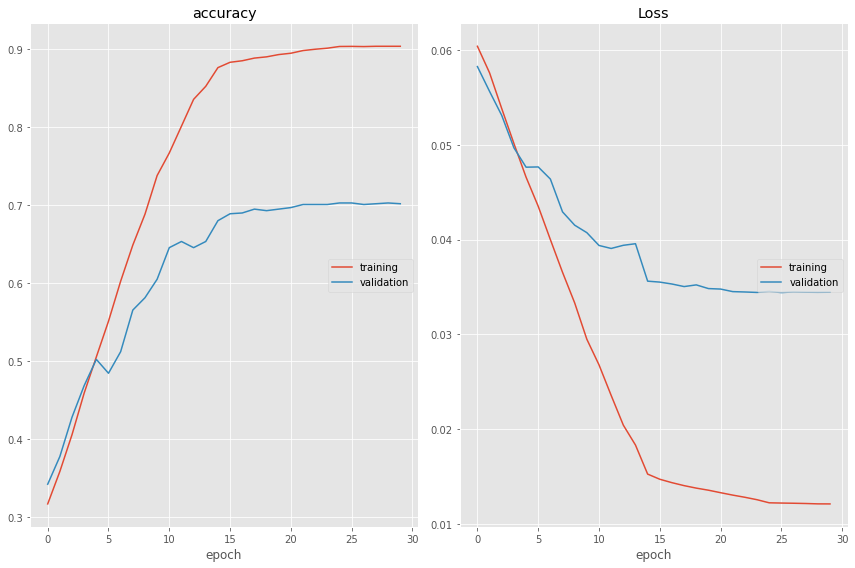

accuracy
	training         	 (min:    0.317, max:    0.904, cur:    0.904)
	validation       	 (min:    0.343, max:    0.703, cur:    0.702)
Loss
	training         	 (min:    0.012, max:    0.060, cur:    0.012)
	validation       	 (min:    0.034, max:    0.058, cur:    0.034)

Epoch 30: saving model to model_weights.h5
257/257 [==============================] - 2s 7ms/step - loss: 0.0121 - accuracy: 0.9036 - val_loss: 0.0344 - val_accuracy: 0.7019 - lr: 1.0000e-05


In [ ]:
embedding_dim = 35
reset_weights(model)
model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

# model.add(layers.Embedding(vocab_size, 35, weights=[w2v_weights],  input_length=max_length)) #For word2vec
model.add(layers.Embedding(vocab_size, 35, weights=[ft_weights],input_length=max_length)) #For fasttext


# model.add(layers.Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))
model.add(layers.Conv1D(128, 7, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
opt = tf.keras.optimizers.Adamax(learning_rate=0.005)
model.compile(loss='logcosh', 
              optimizer=opt, 
              metrics=['accuracy'])
model.summary()


num_epochs = 30
# batch_size = 30

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]


history1 = model.fit(train_padded, y_train, 
                  epochs=num_epochs, 
                  validation_data=(validation_padded, y_val),
                  # batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]


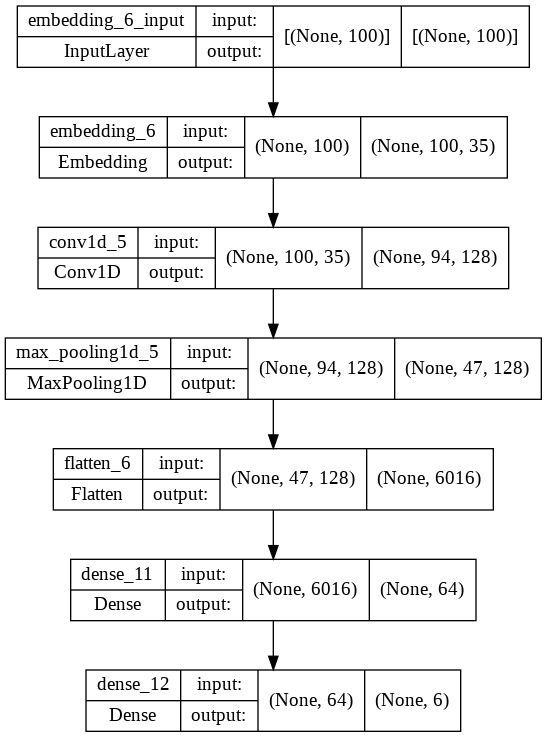

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model94_plot.png', show_shapes=True, show_layer_names=True)

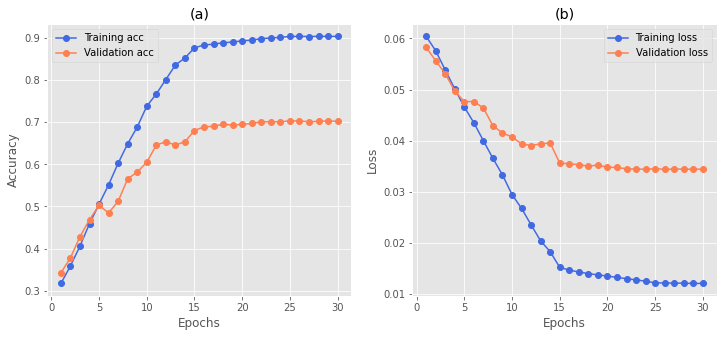

In [ ]:
plot_history(history1.history)
plt.savefig('acc_loss.png', dpi=300)

In [ ]:
history1

In [ ]:
# !cp "/content/drive/My Drive/nlp/emotion/AED 29k/RNN/sg1w2v/model_weights.h5" "/content/"
# !cp "/content/drive/My Drive/nlp/emotion/AED 29k/RNN/sg1w2v/model.json" "/content/"
!cp history1.pkl "/content/drive/MyDrive/"

cp: cannot stat 'history1.pkl': No such file or directory


In [ ]:
with open('history.pkl', 'wb') as p:
  pickle.dump(history.history, p)
import pickle
with open('history1.pkl', 'rb') as p:
  history1 = pickle.load(p)

FileNotFoundError: ignored

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")


Y_pred = loaded_model.predict(test_padded)
y_pred = np.argmax(Y_pred, axis=1)
get_score_table(y_test, y_pred)

Loaded model from disk
Accuracy: 0.7086999022482894
+----------+--------------------+--------------------+--------------------+
|  class   |         f1         |     precision      |       recall       |
+----------+--------------------+--------------------+--------------------+
|  Anger   | 0.7879924953095685 | 0.7984790874524715 | 0.7777777777777778 |
| Disgust  | 0.5723076923076924 | 0.543859649122807  | 0.6038961038961039 |
|   Fear   | 0.7200000000000001 | 0.7226277372262774 | 0.717391304347826  |
|   Joy    | 0.6813186813186813 | 0.7099236641221374 | 0.6549295774647887 |
| Sadness  | 0.6756756756756757 | 0.6648936170212766 | 0.6868131868131868 |
| Surprise | 0.7777777777777777 | 0.7894736842105263 | 0.7664233576642335 |
+----------+--------------------+--------------------+--------------------+


In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
conf_mat=confusion_matrix(y_test, y_pred)
print(conf_mat)

Confusion Matrix
[[210  34   6  11   8   1]
 [ 23  93   3  13  16   6]
 [ 10  11  99   6  10   2]
 [ 14  15   5  93  12   3]
 [  5  11  19   6 125  16]
 [  1   7   5   2  17 105]]


In [ ]:
import numpy as np
conf_mat = np.array([[198,  22,  7,  10,  10,  4],
       [ 20, 100,   5,   16,  12,   1],
       [ 13,   7, 110,  10,  12,  4],
       [ 20,   14,  6, 85,  13,  3],
       [ 5,  14,  9,  11, 118,  6],
       [ 8,  7,  11,  3,  12, 117]])

In [ ]:
import numpy as np
conf_mat = np.array([[210,  34,  6,  11,  8,  1],
       [ 23, 93,   3,   13,  16,   6],
       [ 10,   11, 99,  6,  10,  2],
       [ 14,   15,  5, 93,  12,  3],
       [ 5,  11,  19,  6, 125,  16],
       [ 1,  7,  5,  2,  17, 105]])

In [ ]:
class_names = ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [ ]:
["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

['20.53%',
 '3.32%',
 '0.59%',
 '1.08%',
 '0.78%',
 '0.10%',
 '2.25%',
 '9.09%',
 '0.29%',
 '1.27%',
 '1.56%',
 '0.59%',
 '0.98%',
 '1.08%',
 '9.68%',
 '0.59%',
 '0.98%',
 '0.20%',
 '1.37%',
 '1.47%',
 '0.49%',
 '9.09%',
 '1.17%',
 '0.29%',
 '0.49%',
 '1.08%',
 '1.86%',
 '0.59%',
 '12.22%',
 '1.56%',
 '0.10%',
 '0.68%',
 '0.49%',
 '0.20%',
 '1.66%',
 '10.26%']

In [ ]:
# for cf in conf_mat:
#   print(cf/np.sum(cf))
["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in conf_mat]).flatten()]

['77.78%',
 '12.59%',
 '2.22%',
 '4.07%',
 '2.96%',
 '0.37%',
 '14.94%',
 '60.39%',
 '1.95%',
 '8.44%',
 '10.39%',
 '3.90%',
 '7.25%',
 '7.97%',
 '71.74%',
 '4.35%',
 '7.25%',
 '1.45%',
 '9.86%',
 '10.56%',
 '3.52%',
 '65.49%',
 '8.45%',
 '2.11%',
 '2.75%',
 '6.04%',
 '10.44%',
 '3.30%',
 '68.68%',
 '8.79%',
 '0.73%',
 '5.11%',
 '3.65%',
 '1.46%',
 '12.41%',
 '76.64%']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True, 
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = ["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in conf_mat]).flatten()]

    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        # plt.savefig('filename.png', dpi=300)
    else:
        plt.xlabel(stats_text)
        # plt.savefig('filename.png', dpi=300)
    if title:
        plt.title(title)
        # plt.savefig('filename.png', dpi=300)

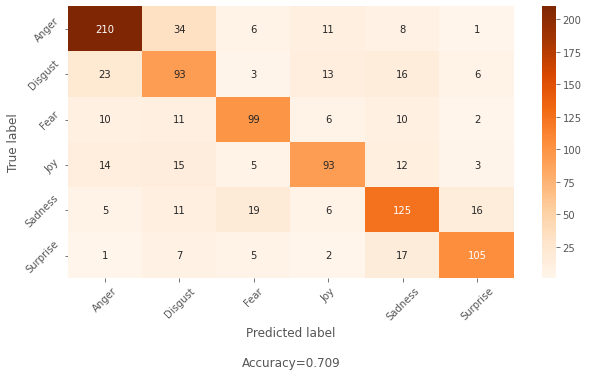

In [ ]:
make_confusion_matrix(conf_mat, figsize=(10,5),percent=False,categories=class_names,cbar=True,cmap='Oranges')
# plt.xlabel('Predicted label')
plt.savefig('conf_mat.png', dpi=300)